ref: https://youtu.be/H9OmsD7F7p0

In [293]:
!pip install pythainlp
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [294]:
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus import thai_stopwords
import pandas as pd
import numpy as np
import string
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [295]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [296]:
data = '/content/drive/MyDrive/Final_project/clean_data/combine_company.csv'

In [371]:
df = pd.read_csv(data)

In [372]:
th_stopword = list(thai_stopwords())
eng_stopword = nltk.corpus.stopwords.words('english')
list_company_detail = []
th_number = ['๑','๒','๓','๔','๕','๖','๗','๘','๙','๐']

def clean_string(text:str) -> str:
    clean_token = text
    for pair in (('\n', ''), ('\t', ''), ('!', '')):
        clean_token =clean_token.replace(*pair)

    clean_token = clean_token.translate(str.maketrans('','',string.punctuation))
    clean_token = str(clean_token).translate(str.maketrans('','',string.digits))
    return clean_token

def clean_stopword(token:list) -> list:
    temp = []
    for i in token:
        if i not in th_stopword and i not in eng_stopword and i not in th_number:
            temp.append(i)
    return temp

for i in range(len(df)):
    sample = clean_string(str(df.iloc[i]['รายละเอียดธุรกิจ']).lower())
    text_cleaned = clean_stopword(word_tokenize(sample, None, 'newmm', False))
    list_company_detail.append(text_cleaned)


# หาค่า TF-IDF

In [373]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [374]:
def identity_fun(text):
    return text

In [375]:
vectorizer = TfidfVectorizer(
    analyzer='word',
    tokenizer=identity_fun,
    preprocessor=identity_fun,
    token_pattern=None,
    lowercase=True,
)


In [376]:
# Train
tfidf_vector = vectorizer.fit_transform(list_company_detail)
tfidf_array = np.array(tfidf_vector.todense())
df_tfidf = pd.DataFrame(tfidf_array, columns=vectorizer.get_feature_names_out())
df_tfidf = df_tfidf.drop(df_tfidf.columns[[k for k in range(-15, 0, 1)]], axis = 1)

# KMeans clustering

In [377]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [378]:
X = df_tfidf
scaler = StandardScaler()
X = scaler.fit_transform(df_tfidf)

# centroids
pca = PCA(n_components=len(df_tfidf))
pca_vecs = pca.fit_transform(df_tfidf)
x_value = pca_vecs[:, 0]
y_value = pca_vecs[:, 1]
df_tfidf['x_value'] = x_value
df_tfidf['y_value'] = y_value

k = 7
kmeans = KMeans(n_clusters=k, random_state=42, max_iter=len(df_tfidf), n_init=1)
# # Fit model
kmeans.fit(df_tfidf[['x_value', 'y_value']])
clusters = kmeans.labels_
df_tfidf['cluster'] = clusters

#  Visualize the Clustering

In [379]:
import matplotlib.pyplot as plt

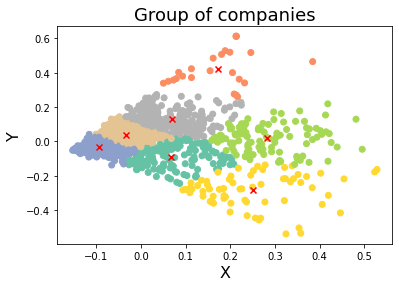

In [380]:
# set image size
# plt.figure(figsize=(10, 5))
# set a title
plt.title("Group of companies", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X", fontdict={"fontsize": 16})
plt.ylabel("Y", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
plt.scatter(x_value, y_value, c=clusters, cmap="Set2")

centroids = kmeans.cluster_centers_
# centroids
plt.scatter(centroids[:,0], centroids[:,1], marker='x', c='red')
# plt.show()
plt.show()

In [395]:
group = []
name = []
for i in range(len(df)):
  if df_tfidf.iloc[i]['cluster'] == 6:
    group.append(df.iloc[i]['รายละเอียดธุรกิจ'])
    name.append(df.iloc[i]['ชื่อย่อสถานประกอบการ'])

sample = pd.DataFrame({
    'name': name,
    'detail': group
}) 

cluster_list = {
    0: "Software",
    1: "Online platform",
    2: "Hardware",
    3: "E-commerce",
    4: "Design",
    5: "AI",
    6: "IT"
}

sample

,name,detail
0,SellSuki,บริการ Platform ระบบบริหารจัดการการขายของออนไล...
1,onebyte,"บริการ พัฒนาระบบสารบบสารสนเทศ Web Application,..."
2,BeNeat,บริการ Platform Web Application และ Mobile App...
3,M® MYBAND,บริการ Platform Web Application และ Mobile App...
4,ShopSpot,บริการ จัดหาระบบตลาดออนไลน์สำหรับการซื้อ-ขายขอ...
...,...,...
207,Digital Life Trend,บริการรับสร้าง ดุแล บริหารจัดการโปรแกรมคอมพิวเ...
208,HAMONIZ InterSoftware,บริการระบบเทคโนโลยีสารสนเทศ Web & Mobile Appli...
209,MEDIABLITZ,บริการลักษณะ Digital Media Agency (Business an...
210,data passion,บริการให้คำปรึกษา ออกแบบ และพัฒนาระบบเทคโนโลยี...
